### Neural Computation Exercise 3: Gradient Descent

In this exercise, we'll develop implementations of gradient descent and its minibatch algorithms. As in Exercise 2, we will use the Boston Housing dataset. Instead of using the exact solution, we use gradient descent and minibatch gradient descent to solve this problem.

In this exercise, you will learn the following
* implement the `gradient descent` method
* implement the `minibatch gradient descent` method

In [1]:
import matplotlib
import numpy as np
import random
import warnings
import matplotlib.pyplot as plt 
from sklearn import preprocessing   # for normalization

## Boston Housing Data

The Boston Housing data is one of the datasets available in sklearn.
We can import the dataset and preprocess it as follows. Note we add a feature of $1$ to `x_input` to get a n x (d+1) matrix `x_in`

In [2]:
from sklearn.datasets import load_boston
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    boston_data = load_boston()
data = boston_data['data']
x_input = data  # a data matrix
y_target = boston_data['target'] # a vector for all outputs
# add a feature 1 to the dataset, then we do not need to consider the bias and weight separately
x_in = np.concatenate([np.ones([np.shape(x_input)[0], 1]), x_input], axis=1)
# we normalize the data so that each has regularity
x_in = preprocessing.normalize(x_in)


## Linear Model

A linear regression model in one variable has the following form 
$$
f(x)=\mathbf{w}^\top \mathbf{x}.
$$
The following function computes the output of the linear model on a data matrix of size n x (d+1).

In [13]:
def linearmat_2(w, X):
    '''
    a vectorization of linearmat_1 in lab 2.
    Input: w is a weight parameter (including the bias), and X is a data matrix (n x (d+1)) (including the feature)
    Output: a vector containing the predictions of linear models
    '''
    return np.dot(X, w)

## Cost Function

We defined the following `mean square error` function for a linear regression problem using the square loss:
$$
C(\mathbf{y}, \mathbf{t}) = \frac{1}{2n}(\mathbf{y}-\mathbf{t})^\top (\mathbf{y}-\mathbf{t}).
$$
The python implementation is as follows

In [4]:
def cost(w, X, y):
    '''
    Evaluate the cost function in a vectorized manner for 
    inputs `X` and outputs `y`, at weights `w`.
    '''
    residual = y - linearmat_2(w, X)  # get the residual
    err = np.dot(residual, residual) / (2 * len(y)) # compute the error
    
    return err

## Gradient Computation

Our methods require to use the gradient of the `cost` function. As discussed in the previous lecture, the gradient can be computed by
$$\nabla C(\mathbf{w}) =\frac{1}{n}X^\top\big(X\mathbf{w}-\mathbf{y}\big)$$
In the following, we present the python implementation on the gradient computation

In [5]:
# Vectorized gradient function
def gradfn(weights, X, y):
    '''
    Given `weights` - a current "Guess" of what our weights should be
          `X` - matrix of shape (N,d+1) of input features including the feature $1$
          `y` - target y values
    Return gradient of each weight evaluated at the current value
    '''

    y_pred = np.dot(X, weights)
    error = y_pred - y
    return np.dot(X.T, error) / len(y)

## Gradient Descent

Gradient Descent iteratively updates the model by moving along the negative direction
$$\mathbf{w}^{(t+1)} \leftarrow \mathbf{w}^{(t)} - \eta\nabla C(\mathbf{w}^{(t)}),$$ 
where $\eta$ is a learning rate and $\nabla C(w^{(t)})$ is the gradient evaluated at current parameter value $\mathbf{w}^{(t)}$. In the following, we give the python implementation of the gradient descent on the linear regression problem. Here, we use `idx_res` to store the indices of iterations where we have computed the cost, and use `err_res` to store the cost of models at these iterations. These will be used to plot how the `cost` will behave `versus iteration` number.

In [7]:
def solve_via_gradient_descent(X, y, print_every=100,
                               niter=2000, eta=1):
    '''
    Solves for linear regression weights with gradient descent.
    Given `X` - matrix of shape (N,D) of input features
          `y` - target y values
          `print_every` - we report performance every 'print_every' iterations
          `niter` - the number of iterates allowed
          `eta` - learning rate
    
    Return 
        `w` - weights after `niter` iterations
        `idx_res` - the indices of iterations where we compute the cost
        `err_res` - the cost at iterations indicated by idx_res
    '''
    N, D = np.shape(X)
    # initialize all the weights to zeros
    w = np.zeros([D])
    idx_res = []
    err_res = []
    for k in range(niter):
        # compute the gradient
        dw = gradfn(w, X, y)
        # gradient descent
        w = w - eta * dw
        # we report the progress every print_every iterations
        # note the operator % calculates the remainder of dividing two values
        if k % print_every == print_every - 1:
            t_cost = cost(w, X, y)
            print('error after %d iteration: %s' % (k, t_cost))
            idx_res.append(k)
            err_res.append(t_cost)
    return w, idx_res, err_res

Now we apply **gradient descent** to solve the **Boston House Price** prediction problem , and get the weight w_gd, the indices idx_gd and the errors 'err_gd' on these indices

In [8]:
w_gd, idx_gd, err_gd = solve_via_gradient_descent( X=x_in, y=y_target)

error after 99 iteration: 31.79169332623316
error after 199 iteration: 31.023607992661905
error after 299 iteration: 30.490383155279737
error after 399 iteration: 30.089558295291933
error after 499 iteration: 29.76576845456071
error after 599 iteration: 29.488693376652886
error after 699 iteration: 29.241419443720748
error after 799 iteration: 29.014275853482015
error after 899 iteration: 28.801555744273426
error after 999 iteration: 28.599760789662742
error after 1099 iteration: 28.406652720498368
error after 1199 iteration: 28.220734140804872
error after 1299 iteration: 28.04095920855528
error after 1399 iteration: 27.866568543075005
error after 1499 iteration: 27.696992152320224
error after 1599 iteration: 27.531790279455226
error after 1699 iteration: 27.370615897731945
error after 1799 iteration: 27.21318994176184
error after 1899 iteration: 27.059284304933392
error after 1999 iteration: 26.908709763895015


## Minibatch Gradient Descent

The optimization problem in ML often has a **sum** structure in the sense
$$
C(\mathbf{w})=\frac{1}{n}\sum_{i=1}^nC_i(\mathbf{w}),
$$
where $C_i(\mathbf{w})$ is the loss of the model $\mathbf{w}$ on the $i$-th example. In our Boston House Price prediction problem, $C_i$ takes the form $C_i(\mathbf{w})=\frac{1}{2}(\mathbf{w}^\top\mathbf{x}^{(i)}-y^{(i)})^2$.

Gradient descent requires to go through all training examples to compute a single gradient, which may be time consuming if the sample size is large. Minibatch gradient descent improves the efficiency by using a subset of training examples to build an **approximate** gradient. At each iteration, it first randomly draws a set $I\subset\{1,2,\ldots,n\}$ of size $s$, where we often call $s$ the minibatch size. Then it builds an approximate gradient by
$$
\nabla_I(\mathbf{w}^{(t)})=\frac{1}{s}\sum_{i\in I}\nabla C_i(\mathbf{w}^{(t)})
$$
Now, it updates the model by
$$
\mathbf{w}^{(t+1)}=\mathbf{w}^{(t)}-\eta_t\nabla_I(\mathbf{w}^{(t)}).
$$ 
It is recommended to use $s\in[20,100]$. Depending on different $s$, minibatch gradient descent recovers several algorithms
\begin{align*}
  s<n \;&\Rightarrow\;\text{Minibatch gradient descent}\\
  s=1 \;&\Rightarrow\;\text{Stochastic gradient descent} 
\end{align*}
In the following, we request you to finish the following implementation of the `minibatch gradient descent` on the linear regression problem. To search a subset of $\{1,2,\ldots,n\}$, we recommend you to use the function `random.sample`. The synatx is `random.sample(sequence, k)`, which returns $k$ length new list of elements chosen from the `sequence`. More details can be found  [here](https://www.geeksforgeeks.org/python-random-sample-function/)

In [9]:
def solve_via_minibatch(X, y, print_every=100,
                               niter=5000, eta=0.2, batch_size=50):
    '''
    Solves for linear regression weights with nesterov momentum.
    Given `X` - matrix of shape (N,D) of input features
          `y` - target y values
          `print_every` - we report performance every 'print_every' iterations
          `niter` - the number of iterates allowed
          `eta` - learning rate
          `batch_size` - the size of minibatch
    Return 
        `w` - weights after `niter` iterations
        `idx_res` - the indices of iterations where we compute the cost
        `err_res` - the cost at iterations
    '''
    N, D = np.shape(X)
    # initialize all the weights to zeros
    w = np.zeros([D])
    idx_res = []
    err_res = []
    tset = list(range(N))
    for k in range(niter):
        # TODO: Insert your code to update w by minibatch gradient descent
        idx = random.sample(tset, batch_size)
        #sample batch of data
        sample_X = X[idx, :]
        sample_y = y[idx]
        dw = gradfn(w, sample_X, sample_y)
        w = w - eta * dw
        if k % print_every == print_every - 1:
            t_cost = cost(w, X, y)
            print('error after %d iteration: %s' % (k, t_cost))
            idx_res.append(k)
            err_res.append(t_cost)
    return w, idx_res, err_res

Now we apply minibatch gradient descent to solve the Boston House Price prediction problem.

In [10]:
w_batch, idx_batch, err_batch = solve_via_minibatch( X=x_in, y=y_target)

error after 99 iteration: 33.27702725723502
error after 199 iteration: 32.57412474323335
error after 299 iteration: 32.20313722160349
error after 399 iteration: 31.99614237775239
error after 499 iteration: 31.934388660382172
error after 599 iteration: 31.632175065523818
error after 699 iteration: 31.424333500073395
error after 799 iteration: 31.31047858817805
error after 899 iteration: 31.165611527847325
error after 999 iteration: 31.00555605744675
error after 1099 iteration: 30.882484699473487
error after 1199 iteration: 30.902934380510015
error after 1299 iteration: 30.724457213716416
error after 1399 iteration: 30.57669847648646
error after 1499 iteration: 30.494388065497176
error after 1599 iteration: 30.45552943671352
error after 1699 iteration: 30.33916726648913
error after 1799 iteration: 30.243250661323835
error after 1899 iteration: 30.160029587814638
error after 1999 iteration: 30.2689146889197
error after 2099 iteration: 30.024488140453713
error after 2199 iteration: 30.1163

### Comparison between Minibatch Gradient Descent and Gradient Descent

We can now compare the behavie of Minibatch Gradient Descent and Gradient Descent. In particular, we will show how the `cost` of models found by the algorithm at different iterations would behave with respect to the iteration number.

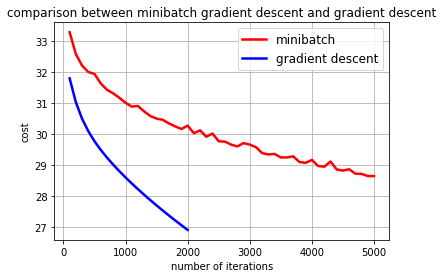

In [11]:
plt.plot(idx_batch, err_batch, color="red", linewidth=2.5, linestyle="-", label="minibatch")
plt.plot(idx_gd, err_gd, color="blue", linewidth=2.5, linestyle="-", label="gradient descent")
plt.legend(loc='upper right', prop={'size': 12})
plt.title('comparison between minibatch gradient descent and gradient descent')
plt.xlabel("number of iterations")
plt.ylabel("cost")
plt.grid()
plt.show()      

As we see, gradient descent converges faster w.r.t. the number of iterations. However, gradient descent requires more computation cost per iteration. Therefore, we cannot conclude that gradient descent is better than minibatch gradient descent in this problem.